In [34]:
#This assignment will use MNIST data to build an active learning model
#We will use the entire MNIST data set, with an 80/20 split for training and testing


#references
1#ttps://en.wikipedia.org/wiki/Active_learning_(machine_learning)


1

In [35]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from graphviz import Digraph

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image

from datetime import datetime

In [36]:

#check data path
data_path = '/../data/mnist/'


mnist_data_file = 'mnist_full_784.npy'
mnist_labels_file = 'mnist_full_labels_784.npy'


if os.path.exists(os.getcwd() + data_path + mnist_data_file):
    X = np.load(os.getcwd() + data_path + mnist_data_file, allow_pickle=True)

if os.path.exists(os.getcwd() + data_path + mnist_labels_file):
    y = np.load(os.getcwd() + data_path + mnist_labels_file, allow_pickle=True)


The active learning algorithm has the following psuedocode  

Input: Dl, Du, h  
Output: h  

Psuedocode from paper
1) Train h using Dl
2) While stopping conditions not met Do  
    1) For each instance Xi in Du  
        1) ui = u(Xi, h)  
    1) End for  
    1) i* = argmax(ui, i)
    2) x* = xi*
    3) y* = query(x*)
    4) Dl = Dl union (x*, y*)
    5) Du = Du subtract x*
    6) Update h based on new Dl
9) End while

My interpretation
utility_value(x) returns the utility value of point x

1) confusion_matrices = []
1) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
1) Dl = empty list
2) Dl.append(choose_first_point(X,y))
2) model = active_learn.fit(Dl)
2) confusion_matrices.append(model)
3) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
3) while not stopping_condition
    3) utility_scores = [utility_value(x) for x in Du]
    3) best_utility_index = argmax(utility_scores)
    4) Dl.append(X_train[best_utility_index], y_train[best_utility_index])
    4) Du.remove(X_train[best_utility_index], y_train[best_utility_index])
    5) model = active_learn.fit(Dl)
    5) confusion_matrices.append(model)
    6) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)    
4) Generate graphs

@article{tharwat2023survey,
  title={A survey on active learning: state-of-the-art, practical challenges and research directions},
  author={Tharwat, Alaa and Schenck, Wolfram},
  journal={Mathematics},
  volume={11},
  number={4},
  pages={820},
  year={2023},
  publisher={MDPI}
}

<https://doi.org/10.3390/math11040820>

Training model on 2 points. Iteration 0 at 2024-04-13 17:52:00.853147
Training time: 0:00:00.425000
Index out of range: 111723
Selected index 28490 for iteration 1
Training model on 3 points. Iteration 1 at 2024-04-13 17:52:01.597793
Training time: 0:00:00.390499
Confusion matrix for iteration 1: [[   0    0    0    0    0    0  729  328  286    0]
 [   0    0    0    0    0    0  214 1293   93    0]
 [   0    0    0    0    0    0  631  540  209    0]
 [   0    0    0    0    0    0  255  367  811    0]
 [   0    0    0    0    0    0  159  916  220    0]
 [   0    0    0    0    0    0  216  560  497    0]
 [   0    0    0    0    0    0  869  468   59    0]
 [   0    0    0    0    0    0   20 1475    8    0]
 [   0    0    0    0    0    0  122  522  713    0]
 [   0    0    0    0    0    0   52 1165  203    0]]
Accuracy for iteration 1: [0.89389271 0.87096774 0.89064976 0.88597119 0.89807163 0.89997643
 0.81570159 0.69266306 0.80752128 0.88712242]
Selected index 12358 for iterati

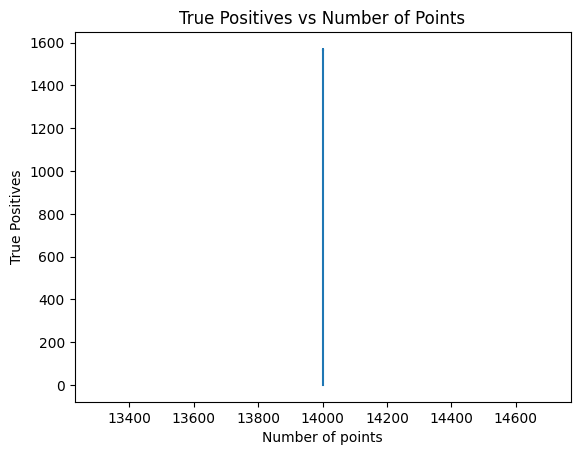

In [58]:
class active_model_learning():
    def __init__(self, model, X, y, X_test=None, y_test=None, accuracy_threshold=0.95, max_iterations=1000, verbose=True, random_state=42, test_size=0.2):
        self.model = model
        
        if X_test is None or y_test is None:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            
        self.Du_X = np.array(X_train); self.Du_y = np.array(y_train); self.Du = (self.Du_X, self.Du_y)
        #match the shape of the data, except for the index column which will be 1
        #shape = list(X.shape); shape[0] = 1; shape = tuple(shape)
        self.Dl_X = np.array([]); self.Dl_y = np.array([]); self.Dl = (self.Dl_X, self.Dl_y)              
        
        self.confusion_matrices = []
        self.calculable_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": [], "pr_auc": []}
        self.accuracy_threshold = accuracy_threshold
        self.accuracy_threshold_reached = False
        self.max_iterations = max_iterations
        self.current_iteration = 0
        self.verbose = verbose
        self.X_test = X_test
        self.y_test = y_test
        self._next_index=0
        
        
        
        
    def _select_point_from_pool(self):
        #place X[index] and y[index] into Dl_X and Dl_y
        if self.Dl_X.shape[0] == 0:
            self.Dl_X = self.Du_X[self._next_index].reshape(1, -1)
            self.Dl_y = np.array([self.Du_y[self._next_index]])
        else:        
            self.Dl_X = np.append(self.Dl_X,self.Du_X[self._next_index].reshape(1, -1), axis=0)
            self.Dl_y = np.append(self.Dl_y, [self.Du_y[self._next_index]], axis=0)
        
        #remove X[index] and y[index] from Du_X and Du_y
        self.Du_X = np.delete(self.Du_X, self._next_index, axis=0)
        self.Du_y = np.delete(self.Du_y, self._next_index, axis=0)
    
    def _train_model(self):
        if self.verbose:
            print(f"Training model on {len(self.Dl_X)} points. Iteration {self.current_iteration} at {datetime.now()}")
            start_time = datetime.now()
            
        self.model.fit(self.Dl_X, self.Dl_y)
        
        if self.verbose:
            print(f"Training time: {datetime.now() - start_time}")
        
    def test_model(self, X, y):
        y_pred = self.model.predict(X)
        self.confusion_matrices.append(confusion_matrix(y, y_pred))
        
        if self.verbose:
            print(f"Confusion matrix for iteration {self.current_iteration}: {self.confusion_matrices[-1]}")
            
    def _test_model(self):            
        self.test_model(self.X_test, self.y_test)        
        
    def evaluate_model(self, X, y):
        self.test_model(X, y)
        
        fp = (self.confusion_matrices[-1].sum(axis=0) - np.diag(self.confusion_matrices[-1]))
        fn = (self.confusion_matrices[-1].sum(axis=1) - np.diag(self.confusion_matrices[-1]))
        tp = np.diag(self.confusion_matrices[-1])
        tn = self.confusion_matrices[-1].sum() - (fn + tp + fn)
        
        accuracy = (tp + tn) / (tp + tn + fn + fp)
        self.calculable_metrics["accuracy"].append(accuracy)
        self.calculable_metrics["precision"].append(tp / (tp + fp))
        self.calculable_metrics["recall"].append(tp / (tp + fn))   
        self.calculable_metrics["f1"].append(2 * (self.calculable_metrics["precision"][-1] * self.calculable_metrics["recall"][-1]) / (self.calculable_metrics["precision"][-1] + self.calculable_metrics["recall"][-1]))
        self.calculable_metrics["roc_auc"].append(roc_auc_score(y, self.model.predict_proba(X)[:, 1]))
        self.calculable_metrics["pr_auc"].append(auc(*precision_recall_curve(y, self.model.predict_proba(X)[:, 1])[:2]))        
        
        if self.verbose:
            print(f"Accuracy for iteration {self.current_iteration}: {accuracy}")
            
        if accuracy.min() >= self.accuracy_threshold:
            self.accuracy_threshold_reached = True
            if self.verbose:
                print(f"Accuracy threshold reached at iteration {self.current_iteration}")
        return accuracy

    def _evaluate_model(self):
        return self.evaluate_model(self.X_test, self.y_test)
        
    def utility_function(self, X):
        #return the point with the highest uncertainty
        return self.model.predict_proba(X)
    
    def utility_function_index(self, X):
        #return the point with the highest uncertainty
        return np.argmax(self.utility_function(X))
    
    def _utility_function_index(self):
        #return the point with the highest uncertainty
        self._next_index = np.argmax(self.utility_function(self.Du_X))
        
        if self._next_index >= self.Du_X.shape[0]:
            if self.verbose:
                print(f"Index out of range: {self._next_index}")
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            
        if self.verbose:
            print(f"Selected index {self._next_index} for iteration {self.current_iteration}")
        return self._next_index
    
    def _run_next(self):
        self.current_iteration += 1
        if self.accuracy_threshold_reached:
            return False
        if self.current_iteration >= self.max_iterations:
            return False
        return True
    
    def report(self):
        print(f"Final accuracy: {self.evaluate_model(self.X_test, self.y_test)}")
        print(f"Final confusion matrix: {self.confusion_matrices[-1]}")
        print(f"Final iteration: {self.current_iteration}")
        print(f"Final accuracy threshold reached: {self.accuracy_threshold_reached}")
    
    def generate_graphs(self):
        fig, ax = plt.subplots()
        ax.plot([np.sum(cm) for cm in self.confusion_matrices], [cm[1][1] for cm in self.confusion_matrices])
        ax.set_xlabel("Number of points")
        ax.set_ylabel("True Positives")
        ax.set_title("True Positives vs Number of Points")
        plt.show()
        return fig, ax
    
    
    def run(self):
        #select a point from the pool at random
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()                     
        
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()
        self._train_model()               
        
        while self._run_next():   
            self._utility_function_index()
            self._select_point_from_pool()
            self._train_model()
            self._evaluate_model()
                        
        if self.verbose:
            print(f"Model training complete at iteration {self.current_iteration}")
            
        return self.accuracy_threshold_reached


    
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
active_learner = active_model_learning(rf_model, X, y, accuracy_threshold=0.95, max_iterations=1000, verbose=True)
active_learner.run()
active_learner.report()
fig, ax = active_learner.generate_graphs()


